In [5]:
import pandas as pd
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.visualization.UserParam import UserSettableParameter                                    
import scipy.stats as ss
import random
import matplotlib.pyplot as plt
import copy
import math
import itertools
from collections import defaultdict

import os

In [6]:
# utility functions

def generate_from_normal(mean, sd, size, low=0, upp=1):
    out = np.random.normal(mean, sd, size)
    return [fix_range(a, low, upp) for a in out]

def fix_range(num, low=0, high=1):
    if num < low:
        return low
    if num > high:
        return high
    return num

# create folder if it does not exist to save images

def init_folders():
    cwd = os.getcwd()
    paths = ['\images','\data']

    for path in paths:
        folder_path = cwd + path
        exists = os.path.exists(folder_path)
        if not exists:
            os.mkdir(folder_path)
            
            

def merge_dicts(d1, d2):
    for key, value in d2.items():
        d1[key].extend(value)
    return d1
            
init_folders()

In [7]:
# SubNetwork properties

# user strikes - needed if subnetwork can kick out the bot
# how many unpopular posts are allowed - opposing views are allowed - no opposing views - some opposing views - random opposing views -all opposing views
# how many irrelevant post are allowed - this will be chance (more like spam filter)

# UNPOPULAR_SCALE = ["LOW", "MEDIUM", "HIGH"]
UNPOPULAR_SCALE = [0.1, 0.5, 0.9]
# UNRELATED_SCALE = ["SOME", "Most"]
UNRELATED_SCALE = [0.1, 0.9]

CURRENT_TOPIC = random.choice([1,2,3,4,5])
MEAN_BELIEF = 0

CELL_PROPERTIES = {}
for x in range(2): # belief scale
    for y in range(3): # moderation scale - negative belief
        for z in range(2): # moderation scale - unrelated
            key = str(x)+"+"+str(y*2+z)
            # stores current topic, belief (pro or against), filter beliefs, random topics, avg_belief
            CELL_PROPERTIES[key] = [CURRENT_TOPIC, x, UNPOPULAR_SCALE[y], UNRELATED_SCALE[z], MEAN_BELIEF]
        


In [8]:
# global constant for posts
# TODO: find justification for these values or change values
INFO_STALENESS_RATE = 0.8
# how much false news influences the view
POST_FALSE_IMPACT = 0.2
# how much the post impacts user belief
POST_BELIEF_IMPACT = 0.2

# how much personality impacts emotion
PERSONALITY_FACTOR = 10

LIKE_THRESHOLD = 0.05
# constant between 0-3 which determines how likely users discover fake news
FAKE_THRESHOLD = 1.3
# how much seeing fake news impact user
FAKE_EMOTION_CHANGE = -0.002
# constant to determine if post and user are in same category how much it impact emotions (multiplicative)
RELEVANT_CONSTANT = 3
# amount of false info user forgets each step
FALSE_INFO_FORGET = -0.005

POSTS = {}
# All the new created posts are in new_posts which will be emptied each step
POST_SIZE = 300

NEW_POSTS = {}
# Popular posts gets saved, population will be used to determine size of this posts.... it will have max capacity and unused ones will be removed
TOP_POSTS = {}
# Posts will be sum of these three dict
HOT_POSTS = {}

# threshold for determining if user should leave group based on difference in beliefs
RELATE_TO_GROUP_THRESHOLD = 1


class Post:
    id_iter = itertools.count()
    
    def __init__(self, timestamp, creator, category, belief, falseness, novelty, sentiment, parent=None):
        self.id = next(self.id_iter)
        self.timestamp = timestamp
        self.creator = creator
        self.category = category
        self.belief = belief
        # 0 means low false information
        self.falseness = falseness
        self.parent = parent
        self.novelty = novelty
        self.sentiment = sentiment
        self.views = 0
        self.children = []
        self.likes = 0
        self.viewers = []
        self.liked_users = []
        self.hot_score = 0
        self.score = 0
        
        
    def __lt__(self, other):
        return self.score < other.score
    
    def __str__(self):
        return "likes-" + str(self.likes)
    
    def __repr__(self):
        return "likes-" + str(self.likes)
    
    def add_to_list(self, position):
        key = str(position[0])+"+"+str(position[1])
        if key in POSTS:
            NEW_POSTS[key].append(self)
        else:
            raise KeyError("Position does not exist")
    
    def increment_like(self, id):
        self.likes += 1
        self.liked_users.append(id)
        

    # shift bits to divide by 8, so new posts have more score to calculate top
    def score_post(self):
        self.score = math.floor(self.likes)
        return self.score


    # shift bits to divide by 8, so new posts have more score to calculate hotness
    def score_hot(self):
        old_score = self.hot_score
        score = math.floor(self.likes<2+self.views>>3)-old_score>1
        self.hot_score = score
        return self.hot_score


def filter_new_posts():
    global NEW_POSTS
    keys = POSTS.keys()
    for key in keys:
        random.shuffle(NEW_POSTS[key])
        # get mean belief
        NEW_POSTS[key] = filter_post(NEW_POSTS[key], key)
        NEW_POSTS[key] = NEW_POSTS[key][:POST_SIZE]
    


# randomly choose top some posts and sort them into hot and top post and remove unwanted posts
def update_posts():
    filter_new_posts()
    get_scored_posts()
    keys = POSTS.keys()
    for key in keys:
        size = len(TOP_POSTS[key])
        if size>POST_SIZE:
            TOP_POSTS[key] = TOP_POSTS[key][:POST_SIZE]
        size = len(HOT_POSTS[key])
        if size>POST_SIZE:
            HOT_POSTS[key] = HOT_POSTS[key][:POST_SIZE]
    # get average belief
    for key in keys:
        try:
            CELL_PROPERTIES[key][4] = np.mean(TOP_POSTS[key])
        except:
            pass
            
        
    
    
def get_scored_posts():
    global NEW_POSTS
    global HOT_POSTS
    global TOP_POSTS
    keys = POSTS.keys()
    ## sort new posts
    TOP_POSTS = merge_dicts(TOP_POSTS, NEW_POSTS)
    HOT_POSTS = merge_dicts(HOT_POSTS, NEW_POSTS)
    
    for key in keys:
        # sort posts
        TOP_POSTS[key] = sorted(TOP_POSTS[key], key=lambda x: x.score_post(), reverse=True)
        HOT_POSTS[key] = sorted(HOT_POSTS[key], key=lambda x: x.score_hot(), reverse=True)
            
# filter posts - moderation
def filter_post(post_list, key):
    cell_category = CELL_PROPERTIES[key][0]
    cell_belief = CELL_PROPERTIES[key][1]
    cell_filter = CELL_PROPERTIES[key][2]
    cell_unrelated = CELL_PROPERTIES[key][3]
    delete_list = []
    for idx, post in enumerate(post_list):
        is_delete_post = False
        is_same_category = post.category == cell_category
        post_belief = 1
        if post.belief < 3:
            post_belief = 0
        is_same_belief = post_belief == cell_belief

        if not is_same_category:
            is_delete_post = random.choices([False, True], [cell_unrelated, 1-cell_unrelated], k=1)[0]
        if not is_same_belief:
            is_delete_post = random.choices([False, True], [cell_filter, 1-cell_filter], k=1)[0]
        if is_delete_post:
            delete_list.append(idx)
    delete_list.reverse()
    for idx in delete_list:
        post_list.pop(idx)
    return post_list
            

In [9]:
class Agent(Agent):    
    def __init__(self, unique_id, model):
      # TODO: find justification for values or change values
        super().__init__(unique_id, model)
        self.agreeableness = 0
        # Emotions: real number from 0 to 1 for each - evolve over time
        # extraversion and neuroticity
        self.E = 0
        self.N = 0
        # postive and negative emotions -> range from -1 to 1
        self.emotions = 0
        # Beliefs - real number from 1 to 5 - evolve over time
        self.belief = 1
        # Activity Level
        # Frequency of posts and post creation per unit time - Real number
        # Time spent in social network per unit of time - Integer - # no of post user sees
        self.activity_level = [1,1]
        # Exposure to false news (measured from all posts interacted with) in unit time
        self.false_exposure = 0
        # Exploration: tendency to join new networks - real number from 0 to 1
        self.exploration = 0.5
        # Stability: tendency to leave a networks - real number from 0 to 1
        self.stablility = 0
        self.position = None
        self.posts_seen = []
        self.posts_liked = []
        self.subnetworks_visited = []
        
        
    def move(self):
        if not self.relate_to_group(self.position) and bool(ss.bernoulli.rvs(self.exploration)):
            n_subnetworks = self.model.width * self.model.height
            if len(self.subnetworks_visited) == n_subnetworks - 1:
                self.subnetworks_visited = []
            self.subnetworks_visited.append(self.position)
            possible_steps = [str(w) + "+" + str(h) for w in range(self.model.width) for h in range(self.model.height)]
            possible_steps.remove(str(self.position[0]) + "+" + str(self.position[1]))
            new_position = self.random.choice(possible_steps)
            tmp = new_position.split('+')
            new_position_formatted = (int(tmp[0]), int(tmp[1]))
            self.model.grid.move_agent(self, new_position_formatted)
   
    def create_new_post(self):
      # TODO: find justifications for values or change values
        post_belief = self.belief + random.uniform(-1, 1)
        post_belief = fix_range(post_belief, 1, 5)
        post_veracity = np.random.normal(self.false_exposure, 0.3, 1)[0]
        post_veracity = fix_range(post_veracity)
        post_novelty = np.random.normal(0.25, 0.3, 1)[0]
        post_novelty = fix_range(post_novelty)
        
        choices = [1,2,3,4,5]
        random.shuffle(choices)
        post_category = random.choices([self.field, choices[0]], [2, 1], k=1)[0]
        
        post_sentiment = np.random.normal(3, 1, 1)[0]
        # relate by extraversion -> more extraversion means more postive post
        # relate by neuroticity -> more neurotic means more negative post
        post_sentiment += (self.E - self.N)
        post_sentiment = fix_range(post_sentiment, 1, 5)
        
        new_post = Post(self.model.current_step, self.unique_id, post_category, post_belief, post_veracity, post_novelty, post_sentiment, None)
        new_post.add_to_list(self.position)
        
    
    def view_post(self, key, idx, post_item, choice):
        # ignore post created by self
        post = None
        
        # look at correct post
        if choice == 1:
            post = TOP_POSTS[key][idx]
        elif choice == 2:
            post = HOT_POSTS[key][idx]
        elif choice == 3:
            post = NEW_POSTS[key][idx]
        if post.creator == self.unique_id:
            return
        
        # post attributes relevant to user
        post.views += 1
        novel_info = post.novelty
        has_seen = False
        
        # impact factor, new posts has greater impact
        # TODO: change this to give newer posts more impact?
        strength = 1
        
        # if post already seen?
        if self.unique_id in post.viewers:
            strength = 0.2 # TODO: justify this?
            novel_info = 0
            has_seen = True
        else:
            post.viewers.append(self.unique_id)
            
        # novelty of post can change depending on its age
        age = self.model.current_step - post.timestamp
        for i in range(age):
            if random.choice([0, 1]):
                novel_info = novel_info*INFO_STALENESS_RATE
                
        # compare if post is as same category as person field to determine relevance
        # relevant post impact emotions more
        post_relevance = 0
        if self.field == post.category:
            post_relevance = 1
        
        # compare belief -> does post agree with their views on a topic or not
        # if less than 3 user views the topic negatively
        # positive orientation means beliefs macthes with the view
        post_orientation = 3-post.belief
        self_orientation = 3-self.belief
        belief_orientaiton = 0                
        if post_orientation*self_orientation < 0:
            belief_orientaiton = -abs(abs(self_orientation)-abs(post_orientation))
        else:
            belief_orientaiton = abs(abs(self_orientation)-abs(post_orientation))
        
        # post emotionality - how positive or negative emotional the post is
        # TODO: incorporate beliefs
        post_emotion = (3- abs(post.sentiment))/2
        
        # does user find post fake or not
        is_fake = self.discover_fake(post, post_emotion, belief_orientaiton, has_seen)           
            
        # update emotions
        self.update_emotion(post, post_emotion, belief_orientaiton, has_seen, is_fake)
        
        # update false_info
        self.update_fasle_info(post, is_fake, has_seen, novel_info)
        
        # update belief
        self.update_belief(post, novel_info, has_seen, is_fake)
        
        
        # likes the post
        # sentiment to determine boring
        if not is_fake:
            if self.unique_id not in post.liked_users:
                self.is_like(post, post_emotion, belief_orientaiton, novel_info)
        # impact emotion
        
            
    """ does this sound correct - trying to determine is this is false """
    def discover_fake(self, post, post_excitement, belief_orientaiton, has_seen):
        fake_val = 0
        # if it does not match with views, users get more skeptical?
        if belief_orientaiton > 0:
            fake_val += post.falseness
        else:
            fake_val += 2*post.falseness
        # if it is more emotional users are less likely to identify fake news
        if abs(post_excitement) > 0.5:
            fake_val = fake_val/2
        # if user is already full of misinformation, they are likely to believe false information more, so the difference of
        # veracity in post and user can be used
        fake_val += (post.falseness - self.false_exposure)
        # too much new infor makes skeptical
#         if not has_seen:
#             fake_val += post.novelty/4
        # Max fake_val is 2+1 = 3.25, so we can have a fake constatnt to know how alert the people are in identifying
        # users know more about their field, thus
        threshold_adjustment = 0
        if self.field == post.category:
            threshold_adjustment = 0.3
            
        if fake_val >= FAKE_THRESHOLD - threshold_adjustment:
            return True
        return False
    
    
    # update emotions based on post
    def update_emotion(self, post, post_emotion, belief_orientaiton, has_seen, is_fake):
        # user feels negative about fake news
        if is_fake:
            emotion_change = FAKE_EMOTION_CHANGE
            self.emotions = fix_range(self.emotions + emotion_change, -1, 1)
            return
        emotion_change = 0
        # if negative post
        if post_emotion < 0:
            emotion_change -= abs(post_emotion)/20
            # if user is agreeable they feel less negative
            # if user is extraverted they are less impacted by negative news
            emotion_change += ((self.E+self.agreeableness)*emotion_change)/PERSONALITY_FACTOR
        if post_emotion > 0:
            emotion_change += abs(post_emotion)/20.15
            # if user is extraverted they are more positive for positive news
            emotion_change += ((self.E)*emotion_change)/PERSONALITY_FACTOR
        # if post is relevant to user
        if self.field == post.category:
            emotion_change = emotion_change*RELEVANT_CONSTANT
        # if post matches their view, they feel slightly good
        if belief_orientaiton > 0:
            emotion_change += emotion_change/10
        # if user has seen post already, then it impacts little
        if has_seen:
            emotion_change = emotion_change/20
            
        self.emotions = fix_range(self.emotions + emotion_change, -1, 1)
        
    
    # update beliefs based on post
    def update_belief(self, post, novel_info, has_seen, is_fake):
        if is_fake:
            return
        belief_change = (post.belief - self.belief) * POST_BELIEF_IMPACT * novel_info
        if has_seen:
            belief_change = belief_change/10
        self.belief = fix_range(self.belief+belief_change, 1, 5)
        
        
    def update_fasle_info(self, post, is_fake, has_seen, novel_info):
        # false exposure decreases over time
        if is_fake:
            false_val = FALSE_INFO_FORGET
            self.false_exposure = fix_range(self.false_exposure+false_val, 0, 1)
            return
        false_val = FALSE_INFO_FORGET
        false_val += post.falseness * POST_FALSE_IMPACT * novel_info
        if has_seen:
            false_val = false_val/10
        self.false_exposure = fix_range(self.false_exposure+false_val, 0, 1)
        
    
    def is_like(self, post, post_emotion, belief_orientaiton, novel_info):
#         if belief_orientaiton > 0:
        if True:
            agent_likes = novel_info * post_emotion
            if agent_likes > LIKE_THRESHOLD:
                post.increment_like(self.unique_id)
    
    
    # function to relfect if user value matches group values or not, if not user leaves
    def relate_to_group(self, key):
        """Return True if user relates to group, False if not"""
        new_key = str(key[0]) + "+" + str(key[1])
        return abs(self.belief - CELL_PROPERTIES[new_key][-1])**2 <= RELATE_TO_GROUP_THRESHOLD
    
    
    # update attribute based on how much user spends time in network
    def update_attributes(self):
        time_spent = generate_from_normal(self.activity_level[1], self.activity_level[1]+3, 1, 0, 1000)[0]
        # visits social media
        time_spent = int(math.floor(time_spent))
        key = str(self.position[0])+"+"+str(self.position[1])
        all_posts = {}
        choice = 3
        if self.model.current_step < 2:
            all_posts = copy.deepcopy(NEW_POSTS[key])
            choice = 3
        else:
            temp = random.choices([(TOP_POSTS[key], 1), (HOT_POSTS[key], 2), (NEW_POSTS[key], 3)], [50, 30, 20], k=1)[0]
            all_posts = copy.deepcopy(temp[0])
            choice = temp[1]
        view_posts = all_posts[:time_spent]
        for idx, post in enumerate(view_posts):
            self.view_post(key, idx, post, choice)
        self.move()
        
    
    
    def step(self):
        num_posts = generate_from_normal(self.activity_level[0], self.activity_level[0]+3, 1, 0, 1000)[0]
        # make a post
        num_posts = int(math.floor(num_posts))
        for i in range(num_posts):
            self.create_new_post()
        self.update_attributes();
        self.move()
        

In [10]:
class SocialModel(Model):
    def __init__(self, num_agents, width, height, agreeableness, field, E, N, emotions, beliefs, activity, news, exploration, stability):
        self.num_agents = num_agents
        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.agreeableness = agreeableness
        
        self.field = field
        self.E = E
        self.N = N
        self.emotions = emotions
        self.beliefs = beliefs
        self.activity = activity
        self.news = news
        self.exploration = exploration
        self.stability = stability
        self.current_step = 0
        
        # random start
        for i in range(self.num_agents):
            a = Agent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            a.position = (x, y)
            # Random 
        
            
        self.datacollector = DataCollector(
#             model_reporters={"belief": mean_belief, "unique views": num_unique_views, "total likes": num_likes}
#             model_reporters={"emotion": mean_emotion, "post sentiment": avg_new_post_emotion}
            model_reporters={"emotion": mean_emotion}
        )
        
        init_population(self)
        init_posts(self)

        
    def step(self):
#         remove_unpopular_posts();
        self.current_step += 1
        self.datacollector.collect(self)
        self.schedule.step()
        update_posts()


        
# initialize conditions
            
def init_posts(model):
    global POSTS
    global NEW_POSTS
    global HOT_POSTS
    global TOP_POSTS
    POSTS = {}
    width = model.width
    height = model.height
    for w in range(width):
        for h in range(height):
            key = str(w)+"+"+str(h)
            POSTS[key] = []
            NEW_POSTS[key] = []
            HOT_POSTS[key] = []
            TOP_POSTS[key] = []
            
            
def init_population(model):
    total_population = model.num_agents
    agreeableness_list = generate_from_normal(model.agreeableness[0], model.agreeableness[1], total_population)
    # personality
    E_list = generate_from_normal(model.E[0], model.N[0], total_population)
    N_list = generate_from_normal(model.E[0], model.N[0], total_population)
    # emotions
    emotions_list = generate_from_normal(model.emotions[0], model.emotions[0], total_population)
    # beliefs
    beliefs_list = generate_from_normal(model.beliefs[0], model.beliefs[1], total_population, 1, 5)
    # beliefs
    act_post_list = generate_from_normal(model.activity[0][0], model.activity[0][1], total_population, 0, 100)
    act_time_list = generate_from_normal(model.activity[1][0], model.activity[1][1], total_population,  0, 100)
    # false news
    false_news_list = generate_from_normal(model.news[0], model.news[1], total_population)
    # exploration
    exploration_list = generate_from_normal(model.exploration[0], model.exploration[1], total_population)
    # stability
    stability_list = generate_from_normal(model.stability[0], model.stability[1], total_population)
    
    for idx, a in enumerate(model.schedule.agents):
        a.agreeableness = agreeableness_list[idx]
        a.emotions = emotions_list[idx]
        a.belief = beliefs_list[idx]
        a.field = random.choices([1, 2, 3, 4, 5], [20, 20, 20, 20, 20], k=1)[0]
        a.E = E_list[idx]
        a.N = N_list[idx]
        a.activity_level = [math.floor(act_post_list[idx]), math.floor(act_time_list[idx])]
        a.false_exposure = false_news_list[idx]
        a.exploration = exploration_list[idx]
        a.stablility = stability_list[idx]


def mean_belief(model):
    total_beliefs = [agent.belief for agent in model.schedule.agents]
    N = model.num_agents
    B = float(sum(total_beliefs))
    return B/N


def mean_emotion(model):
    total_emotions = [agent.emotions for agent in model.schedule.agents]
    N = model.num_agents
    B = float(sum(total_emotions))
    return B/N

def num_posts(model):
    posts_count = [len(item) for item in TOP_POSTS.values()]
    return sum(posts_count)

def avg_new_post_emotion(model):
    emotions = []
    for key in NEW_POSTS.keys():
        length = len(NEW_POSTS[key])
        if length == 0:
            length = 1
        sentiments = [x.sentiment for x in NEW_POSTS[key]]
        emotions.append(float(sum(sentiments))/length)
    if len(emotions):
        return (3-float(sum(emotions))/len(emotions))/2
    return 0

def avg_network_size(model):
    return 0

def num_total_views(model):
    posts_count = [item for item in TOP_POSTS.values()]
    views_count = 0
    for posts in posts_count:
        test = sum([post.views for post in posts])
        views_count += test
    return views_count

def num_unique_views(model):
    posts_count = [item for item in TOP_POSTS.values()]
    views_count = 0
    for posts in posts_count:
        test = sum([len(post.viewers) for post in posts])
        views_count += test
    return views_count


In [11]:
# default settings

# num_agents, width, height, agreeableness, emotions, beliefs, activity, news, exploration, stability
def reset_default():
    global NUM_STEP
    
    global POPULATION
    global WIDTH
    global HEIGHT
    
    global AGREEABLENESS
    global FIELD
    
    global E
    global N
    
    global BELIEFS
    
    global ACT_POSTS
    global ACT_TIME
    
    global FALSE_EXPOSURE
    
    global EXPLORATION
    global STABILITY
    
    global EMOTIONS
    global ACTIVITY_LEVEL
    
    NUM_STEP = 10
    
    POPULATION = 500
#     POPULATION = 10
    WIDTH = 2
    HEIGHT = 6
    
    # mean and variance
    AGREEABLENESS = [0.5, 0.3]
    FIELD = 1
    
    E = [0.5, 0.3]
    N = [0.5, 0.3]
    
    EMOTIONS = [0, 0.5]
    
    BELIEFS = [3, 2]
    
    ACT_POSTS = [0.3, 0.3]
    ACT_TIME = [10, 20]
    
    ACTIVITY_LEVEL = [ACT_POSTS, ACT_TIME]
    
    FALSE_EXPOSURE = [0.3, 0.2]
    
    EXPLORATION = [0.5, 0.4]
    STABILITY = [0.5, 0.4]

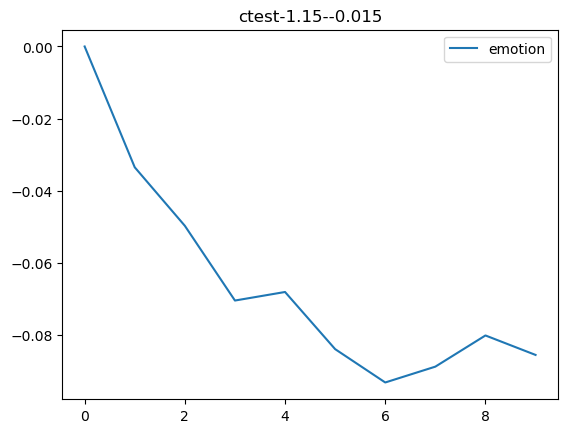

<Figure size 640x480 with 0 Axes>

In [12]:
# Default Model Run
import time
start_time = time.time()
reset_default()

for a in [1.15]:
    for b in [-0.015]:
        FAKE_THRESHOLD = a
        # how much seeing fake news impact user
        FAKE_EMOTION_CHANGE = b

        model = SocialModel(POPULATION, WIDTH, HEIGHT, AGREEABLENESS, FIELD, E, N, EMOTIONS, BELIEFS, ACTIVITY_LEVEL, FALSE_EXPOSURE, EXPLORATION, STABILITY)
        for i in range(NUM_STEP):
            model.step()
        #     for key in POSTS.keys():
        #         print(len(POSTS[key]))
        df = model.datacollector.get_model_vars_dataframe()
    #     print(df.head())
        title = "ctest-"+str(a)+'-'+str(b)
        #     covid_df.to_csv("data/"+title+".csv", index=False)
        plot = df.plot(title=title)
        fig = plt.figure()
        fig = plot.get_figure()
#     print("--- %s seconds ---" % (time.time() - start_time))
#         fig.savefig("images/" + title+".png")

In [ ]:
keys = TOP_POSTS.keys()
# for key in keys:
#     TOP_POSTS[key][0].likes
#     TOP_POSTS[key][1].likes
for key in keys:
    print(key)
    print(TOP_POSTS[key])

In [ ]:
print(TOP_POSTS["0+1"][0].viewers, TOP_POSTS["0+1"][0].views, TOP_POSTS["0+1"][0].likes)

In [ ]:
fig, ax = plt.subplots()
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
im = ax.imshow(agent_counts, interpolation="nearest")
ax.set_yticks([-0.5, 0, 0.5, 1, 1.5])
ax.set_yticklabels(['', 'AGAINST', '', 'PRO',''])
ax.set_xticks(list(range(6)))
ax.set_xticklabels(['LOW UNPOP,\nSOME UNREL','LOW UNPOP,\nMOST UNREL','MED UNPOP,\nSOME UNREL',
                    'MED UNPOP,\nMOST UNREL','HIGH UNPOP,\nSOME UNREL','HIGH UNPOP,\nMOST UNREL'], size=6)
ax.set_title('Number of Users in Each Subnetwork')
plt.colorbar(im)
fig.savefig('test.png')
plt.show()